### Erddap Quicklooks of ThingSpeak archived data

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
```

In [153]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-10-17 09:38:21.857964


In [154]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in ['channel_843357_thingspeak']]
print(variables)

[['SLP', 'RH_Percent', 'Temp', 'BaroTemp', 'time']]


In [155]:

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='channel_843357_thingspeak'

d.variables =  [d.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in [d.dataset_id]][0]

d.constraints = {
    'time>=': datetime.datetime.today()-datetime.timedelta(days=30),
    'time<=': datetime.datetime.utcnow()
}

d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/channel_843357_thingspeak.csv?SLP,RH_Percent,Temp,BaroTemp,time&time>=1568713102.008949&time<=1571330302.00896'

In [156]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,SLP,RH_Percent,Temp,BaroTemp
time (UTC),,,,
2019-10-17 15:54:32+00:00,999.0,45.0,24.0,24.5
2019-10-17 15:55:40+00:00,999.0,45.0,24.0,24.5
2019-10-17 15:56:47+00:00,999.0,45.0,23.9,24.5
2019-10-17 15:57:54+00:00,999.0,45.0,23.9,24.5
2019-10-17 15:59:01+00:00,999.0,45.0,23.9,24.4


In [157]:
datetime.datetime.utcnow()

datetime.datetime(2019, 10, 17, 16, 38, 29, 665938)

In [158]:
#get some nearby data
import requests
import xml.etree.ElementTree as ET

user_agent_url = 'https://w1.weather.gov/xml/current_obs/KPAE.xml'
kpae = {} #Payne Field
try:
    xml_data = requests.get(user_agent_url).content
    res = requests.get("http://w1.weather.gov/xml/current_obs/KPAE.xml")
    xml_tree = ET.fromstring(res.text)
    kpae['temp_c'] = xml_tree.find('temp_c').text
    kpae['relative_humidity'] = xml_tree.find('relative_humidity').text
    kpae['pressure_mb'] = xml_tree.find('pressure_mb').text
    kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text
    kpae['datetime'] = datetime.datetime.strptime(kpae['observation_time_rfc822'],'%a, %d %b %Y %H:%M:%S %z')
except:
    pass

kpae

{'temp_c': '10.6',
 'relative_humidity': '83',
 'pressure_mb': '1004.6',
 'observation_time_rfc822': 'Thu, 17 Oct 2019 08:53:00 -0700',
 'datetime': datetime.datetime(2019, 10, 17, 8, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=61200)))}

In [159]:
kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text

In [160]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Average difference between two sensors for all time: -0.44974528431775246
Average difference between two sensors for last two weeks: -0.30080519111448817
Average difference between two sensors for last two days: -0.48468132687290166


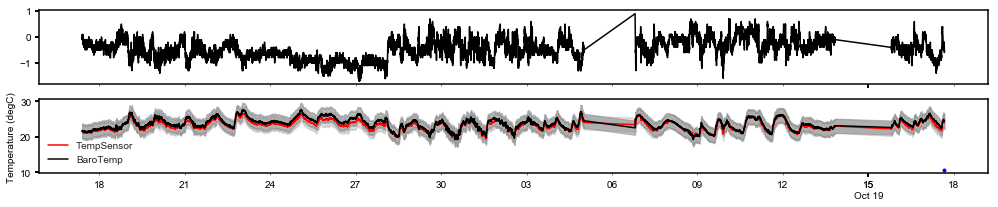

In [161]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['Temp'],'r',df.index,df['BaroTemp'],'k')
ax1.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
ax1.fill_between(df.index,df['BaroTemp']-2,df['BaroTemp']+2,color='grey',alpha=.5)
ax2.plot(df.index,df['Temp']-df['BaroTemp'],'k')
plt.ylabel('Temperature (degC)')


try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
except:
    pass

plt.legend(['TempSensor','BaroTemp'])
#ax1.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

print(f"Average difference between two sensors for all time: {(df['Temp']-df['BaroTemp']).mean()}")
two_weeks_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(14, 'D'):] - 
                  df['BaroTemp'][df.last_valid_index()-pd.DateOffset(14, 'D'):]).mean()
print(f"Average difference between two sensors for last two weeks: {two_weeks_delta}")
two_days_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(2, 'D'):] - 
                  df['BaroTemp'][df.last_valid_index()-pd.DateOffset(2, 'D'):]).mean()
print(f"Average difference between two sensors for last two days: {two_days_delta}")

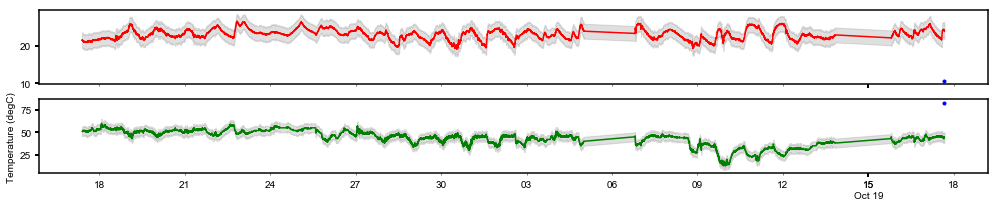

In [162]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['RH_Percent'],'g')
ax1.fill_between(df.index,df['RH_Percent']-5,df['RH_Percent']+5,color='grey',alpha=.25)
ax2.plot(df.index,df['Temp'],'r')
ax2.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
plt.ylabel('Temperature (degC)')

try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['relative_humidity']),'ob',markersize=3)
    ax2.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

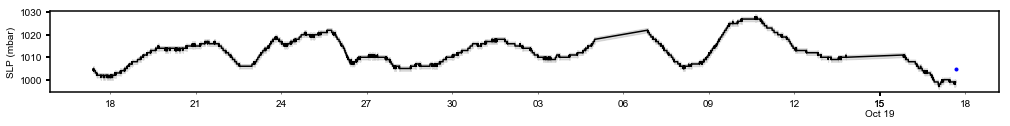

In [163]:
fig, ax1 = plt.subplots(1,1,sharex='col',figsize=(17,1.5))
ax1.plot(df.index,df['SLP'],'k')
ax1.fill_between(df.index,df['SLP']-1,df['SLP']+1,color='grey',alpha=.25)
plt.ylabel('SLP (mbar)')

try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['pressure_mb']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

In [164]:
### build a table of daily max/min
daily_summary = pd.DataFrame(columns=df.columns)

for column in daily_summary:
    daily_summary[column+' (min)'] = df[column].resample('D').min()
    daily_summary[column+' (max)'] = df[column].resample('D').max()
    daily_summary[column+' (median)'] = df[column].resample('D').median()
    daily_summary[column] = df[column].resample('D').mean()
    


In [165]:
def highlight_max(s):
    '''
    highlight the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]



In [166]:
daily_summary.style.apply(highlight_max).apply(highlight_min).format("{:.2f}")

,SLP,RH_Percent,Temp,BaroTemp,SLP (min),SLP (max),SLP (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),Temp (min),Temp (max),Temp (median),BaroTemp (min),BaroTemp (max),BaroTemp (median)
time (UTC),,,,,,,,,,,,,,,,
2019-09-17 00:00:00+00:00,1002.05,52.00,21.39,21.70,1001.00,1005.00,1002.00,50.00,55.00,52.00,21.00,21.90,21.40,21.20,22.30,21.60
2019-09-18 00:00:00+00:00,1005.01,53.83,22.39,22.67,1001.00,1009.00,1004.00,49.00,60.00,54.00,21.20,24.10,22.10,21.60,24.20,22.50
2019-09-19 00:00:00+00:00,1012.47,49.82,23.50,24.07,1009.00,1015.00,1013.00,43.00,54.00,50.00,21.60,25.90,23.30,22.00,26.90,23.70
2019-09-20 00:00:00+00:00,1014.28,50.31,23.27,23.88,1013.00,1016.00,1014.00,44.00,55.00,51.00,22.00,25.10,23.00,22.30,25.90,23.50
2019-09-21 00:00:00+00:00,1015.67,51.37,23.41,24.01,1013.00,1017.00,1016.00,46.00,55.00,52.00,22.00,24.90,23.40,22.50,25.80,24.10
2019-09-22 00:00:00+00:00,1008.03,51.28,24.25,24.73,1006.00,1013.00,1007.00,46.00,59.00,50.00,22.10,26.70,24.40,22.30,27.00,24.90
2019-09-23 00:00:00+00:00,1013.85,51.14,24.12,24.84,1007.00,1019.00,1014.00,48.00,54.00,52.00,23.00,26.50,23.60,23.60,27.60,24.30
2019-09-24 00:00:00+00:00,1017.86,54.34,23.61,24.32,1015.00,1021.00,1018.00,51.00,57.00,55.00,22.70,25.30,23.60,23.40,26.40,24.20
2019-09-25 00:00:00+00:00,1020.44,51.17,24.68,25.66,1018.00,1022.00,1020.00,40.00,55.00,53.00,22.90,26.50,24.70,24.00,27.60,25.90


In [167]:
(daily_summary - daily_summary.mean()).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])


,SLP,RH_Percent,Temp,BaroTemp,SLP (min),SLP (max),SLP (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),Temp (min),Temp (max),Temp (median),BaroTemp (min),BaroTemp (max),BaroTemp (median)
time (UTC),,,,,,,,,,,,,,,,
2019-09-17 00:00:00+00:00,-10.3823,8.79329,-1.84345,-1.99272,-8.36667,-10.2,-10.4333,13.8,6.2,8.06667,-0.4,-3.16333,-1.86333,-0.48,-3.35,-2.15
2019-09-18 00:00:00+00:00,-7.42304,10.6181,-0.846834,-1.02594,-8.36667,-6.2,-8.43333,12.8,11.2,10.0667,-0.2,-0.963333,-1.16333,-0.08,-1.45,-1.25
2019-09-19 00:00:00+00:00,0.0450107,6.61111,0.265666,0.382256,-0.366667,-0.2,0.566667,6.8,5.2,6.06667,0.2,0.836667,0.0366667,0.32,1.25,-0.05
2019-09-20 00:00:00+00:00,1.84779,7.10208,0.033652,0.183923,3.63333,0.8,1.56667,7.8,6.2,7.06667,0.6,0.0366667,-0.263333,0.62,0.25,-0.25
2019-09-21 00:00:00+00:00,3.24593,8.16363,0.168717,0.315168,3.63333,1.8,3.56667,9.8,6.2,8.06667,0.6,-0.163333,0.136667,0.82,0.15,0.35
2019-09-22 00:00:00+00:00,-4.4015,8.06616,1.01237,1.04075,-3.36667,-2.2,-5.43333,9.8,10.2,6.06667,0.7,1.63667,1.13667,0.62,1.35,1.15
2019-09-23 00:00:00+00:00,1.42636,7.92629,0.883984,1.15146,-2.36667,3.8,1.56667,11.8,5.2,8.06667,1.6,1.43667,0.336667,1.92,1.95,0.55
2019-09-24 00:00:00+00:00,5.4338,11.1322,0.374632,0.629702,5.63333,5.8,5.56667,14.8,8.2,11.0667,1.3,0.236667,0.336667,1.72,0.75,0.45
2019-09-25 00:00:00+00:00,8.01168,7.95694,1.43796,1.97184,8.63333,6.8,7.56667,3.8,6.2,9.06667,1.5,1.43667,1.43667,2.32,1.95,2.15
